Extracting Features: 100%|██████████| 6714/6714 [21:06<00:00,  5.30it/s]


Random Forest Accuracy: 0.8561
XGBoost Accuracy: 0.7996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31640
[LightGBM] [Info] Number of data points in the train set: 32227, number of used features: 153
[LightGBM] [Info] Start training from score -2.945122
[LightGBM] [Info] Start training from score -2.191871
[LightGBM] [Info] Start training from score -1.833808
[LightGBM] [Info] Start training from score -2.083266
[LightGBM] [Info] Start training from score -2.914905
[LightGBM] [Info] Start training from score -3.056070
[LightGBM] [Info] Start training from score -1.457635
[LightGBM] [Info] Start training from score -1.766240
[LightGBM] [Info] Start training from score -3.072017
LightGBM Accuracy: 0.7559


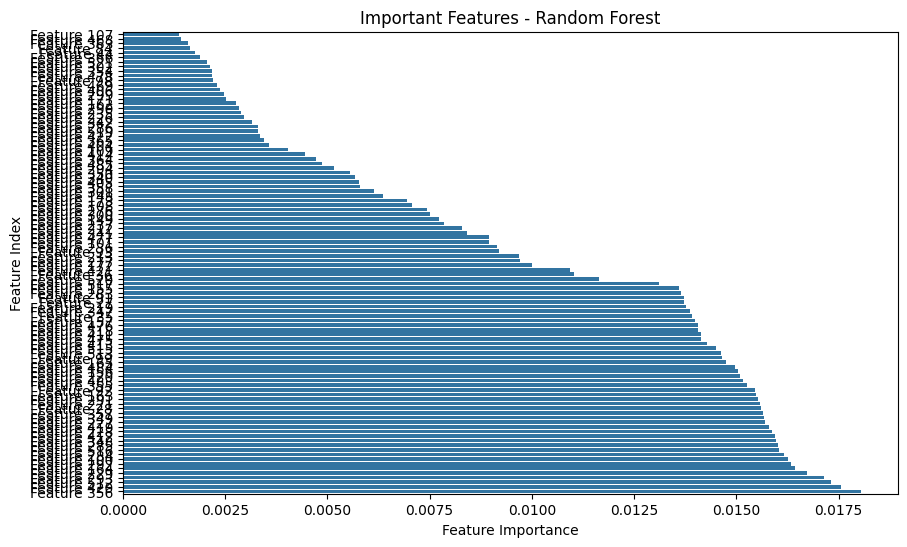

In [4]:
import numpy as np
import os
import cv2
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Data Augmentation
def augment_image(image):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(p=0.3),
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.3),
    ])
    return transform(image=image)['image']

# Feature Extraction
def extract_color_histogram(image, bins=(8, 8, 8)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_contour_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(3, dtype=np.float32)
    largest_contour = max(contours, key=cv2.contourArea)
    return np.array([cv2.contourArea(largest_contour), cv2.arcLength(largest_contour, True), 0], dtype=np.float32)

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)

image_paths = glob.glob("D:/ML/Mushrooms/*/*.jpg")

labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

X, y = [], []
for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Extracting Features"):
    image = cv2.imread(path)
    if image is None:
        continue
    
    color_hist = extract_color_histogram(image)
    contour_feat = extract_contour_features(image)
    hu_moments = extract_hu_moments(image)
    features = np.hstack([color_hist, contour_feat, hu_moments])

    X.append(features)
    y.append(label)
    
    for _ in range(5):  
        aug_img = augment_image(image)
        aug_color_hist = extract_color_histogram(aug_img)
        aug_contour_feat = extract_contour_features(aug_img)
        aug_hu_moments = extract_hu_moments(aug_img)
        aug_features = np.hstack([aug_color_hist, aug_contour_feat, aug_hu_moments])
        X.append(aug_features)
        y.append(label)

X = np.array(X, dtype=object)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle NaN
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest to get important features
rf = RandomForestClassifier(n_estimators=333, max_depth=40, random_state=42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
top_100_idx = np.argsort(feature_importances)[-200:]
X_train = X_train[:, top_100_idx]
X_test = X_test[:, top_100_idx]

# Train and evaluate models
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")

# Plot feature importance
sorted_idx = np.argsort(feature_importances)[-100:]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx], y=[f"Feature {i}" for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Index")
plt.title("Important Features - Random Forest")
plt.show()
